# QAOA for Max-Cut Problem

This is an example of using PennyLane to solve the Max-Cut problem (combinatorial optimization) using the Quantum Approximate Optimization Algorithm (QAOA).

- Define a small graph (e.g., 4 nodes).
- Build the cost Hamiltonian for MaxCut.
- Define the QAOA ansatz circuit.
- Optimize the parameters.
- Plot cost function vs iteration.
- Visualize the final cut on the graph.

References:
- [PennyLane Intro to QAOA](https://pennylane.ai/qml/demos/tutorial_qaoa_intro)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

## Define a simple 4-node graph for MaxCut

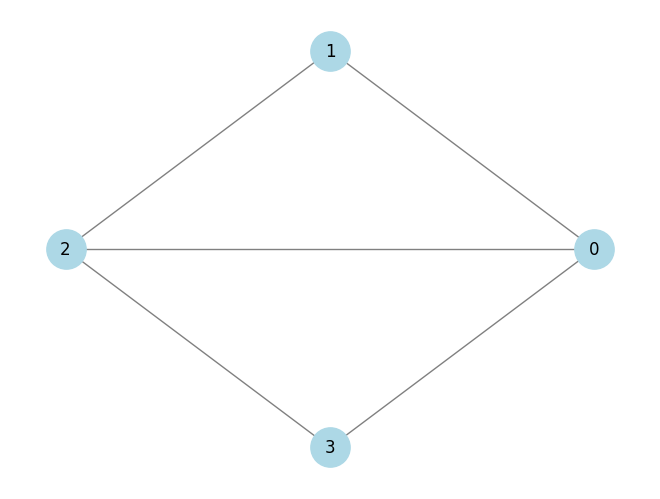

In [2]:
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,3), (3,0), (0,2)])

nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=800, edge_color='gray')
plt.show()

## Cost Hamiltonian for MaxCut

The MaxCut cost Hamiltonian is:

$$
\hat{H}_{\text{cost}} = \frac{1}{2} \sum_{(i,j) \in E} (I - Z_i Z_j)
$$

We build this using PennyLane's `qml.qaoa.maxcut` utility.


In [3]:
# Get number of qubits
num_qubits = len(G.nodes)

# Build the cost Hamiltonian
cost_h, mixer_h = qml.qaoa.maxcut(G)

print("Cost Hamiltonian:")
print(cost_h)
print("Mixer Hamiltonian:")
print(mixer_h)

Cost Hamiltonian:
0.5 * (Z(0) @ Z(1)) + 0.5 * (Z(0) @ Z(3)) + 0.5 * (Z(0) @ Z(2)) + 0.5 * (Z(1) @ Z(2)) + 0.5 * (Z(2) @ Z(3)) + -0.5 * (I(0) @ I(1)) + -0.5 * (I(0) @ I(3)) + -0.5 * (I(0) @ I(2)) + -0.5 * (I(1) @ I(2)) + -0.5 * (I(2) @ I(3))
Mixer Hamiltonian:
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


## QAOA Ansatz

We use p layers of alternating cost and mixer unitaries.

The mixer Hamiltonian is typically a sum of Pauli-X operators on each qubit. 

This is a common choice for QAOA. It encourages exploration of the solution space by flipping qubits.

Here, we use the X mixer for all qubits.

The mixer Hamiltonian is defined as:
$$ \hat{H}_{\text{mixer}} = \sum_{i=0}^{n-1} X_i $$
where $X_i$ is the Pauli-X operator on qubit $i$.

In [4]:
# Define the QAOA layer
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)


# Define the QAOA ansatz which is a pure gate sequence, no measurement.
def qaoa_ansatz(params):
    # Start in equal superposition
    for wire in range(num_qubits):
        qml.Hadamard(wire)
    
    # Apply p layers of QAOA
    qml.layer(qaoa_layer, 2, params[0], params[1])



## Cost Function

We want to minimize ⟨H⟩ = cost(params).

In [5]:
# Define the quantum device
dev = qml.device('default.qubit', wires=num_qubits)


@qml.qnode(dev)
def cost_function(params):
    qaoa_ansatz(params)
    return qml.expval(cost_h)

Note: params shape is (p, 2), where p = number of layers.

## Optimize the QAOA parameters

In [6]:
np.random.seed(42) # Set random seed for reproducibility

p = 2
params = np.random.uniform(0, np.pi, (p, 2), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
cost_progress = []

for i in range(max_iterations):
    params, cost_val = opt.step_and_cost(cost_function, params)
    cost_progress.append(cost_val)
    if i % 10 == 0:
        print(f"Iteration {i}: Cost = {cost_val:.4f}")


Iteration 0: Cost = -1.6569
Iteration 10: Cost = -3.2516
Iteration 20: Cost = -3.6170
Iteration 30: Cost = -3.7164
Iteration 40: Cost = -3.7274
Iteration 50: Cost = -3.7374
Iteration 60: Cost = -3.7391
Iteration 70: Cost = -3.7416
Iteration 80: Cost = -3.7416
Iteration 90: Cost = -3.7420


## Plot cost function vs iteration

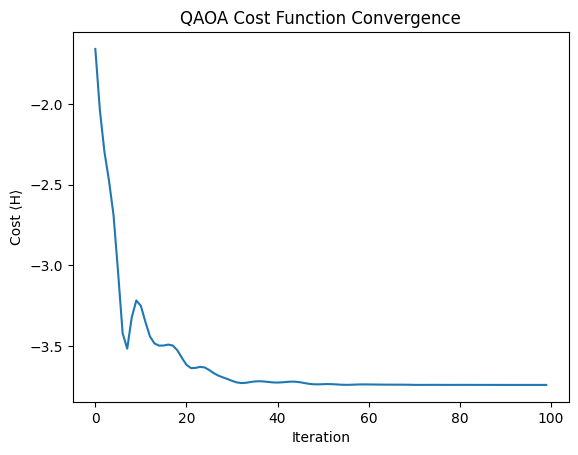

In [7]:
plt.plot(cost_progress)
plt.xlabel("Iteration")
plt.ylabel("Cost ⟨H⟩")
plt.title("QAOA Cost Function Convergence")
plt.show()

## Sample and Visualize Cut

Final cut assignment: [[0. 1. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 1. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


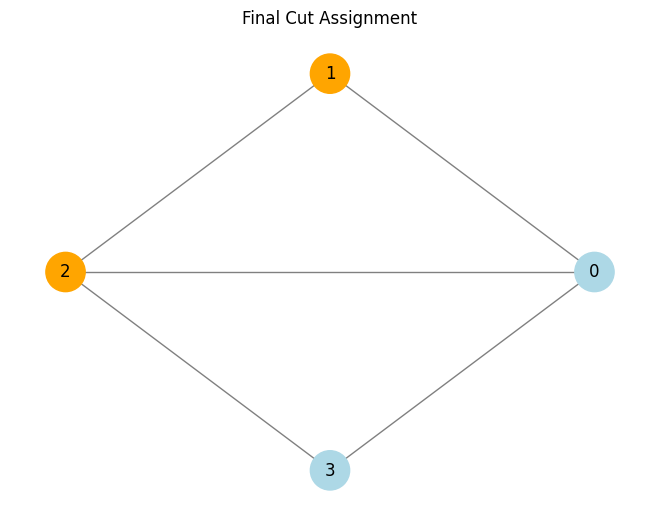

In [14]:
# For sampling the final state, we will use a new device with shots.
dev = qml.device('default.qubit', wires=num_qubits, shots=1000)


# Define a QNode to sample the final state after optimization
@qml.qnode(dev)
def final_state(params):
    qaoa_ansatz(params)
    return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]


# Sample the final state
samples = np.array(final_state(params))
cut = (samples + 1) // 2
print("Final cut assignment:", cut)

# Visualize the final cut assignment
assignment = cut[0]
color_map = ['lightblue' if assignment[i]==0 else 'orange' for i in G.nodes]
nx.draw_circular(G, with_labels=True, node_color=color_map, node_size=800, edge_color='gray')
plt.title("Final Cut Assignment")
plt.show()